Use this notebook to run 1 denoiser step and get updated intermediate steps

In [1]:
import torch
from torch.testing import assert_close
from torch import allclose, nn, tensor
torch.set_printoptions(linewidth=200)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
device_dtype = torch.float16 if device == 'cuda' else torch.float32

## Load the model

In [3]:
from diffusers import StableDiffusionXLPipeline
from diffusers import EulerDiscreteScheduler
from diffusers.models.controlnetxs import ControlNetXSModel
from diffusers.pipelines.controlnet_xs.pipeline_controlnet_xs_sd_xl import StableDiffusionXLControlNetXSPipeline

In [4]:
sdxl_pipe = StableDiffusionXLPipeline.from_single_file('weights/sdxl/sd_xl_base_1.0_0.9vae.safetensors').to(device)
cnxs = ControlNetXSModel.from_pretrained('weights/cnxs').to(device)

In [5]:
cnxs.base_model = sdxl_pipe.unet

The example script of Heidelberg manually sets scale_list to 0.95

In [6]:
cnxs.scale_list = cnxs.scale_list * 0. + 0.95
assert cnxs.scale_list[0] == .95

Heidelberg uses `timestep_spacing = 'linspace'` in their scheduler, so let's do that as well

In [7]:
scheduler_cgf = dict(sdxl_pipe.scheduler.config)
scheduler_cgf['timestep_spacing'] = 'linspace'
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

# test it worked
sdxl_pipe.scheduler.set_timesteps(50)
assert sdxl_pipe.scheduler.timesteps[0]==999

# reset
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

timestep_spacing = "leading" and timesteps=[999.      978.61224 958.2245  937.83673 917.449  ] ...
sigmas before interpolation: [0.02916753 0.04131448 0.05068044 0.05861427 0.06563709] ...
sigmas after (linear) interpolation: [14.61464691 12.93677721 11.49164976 10.24291444  9.16035419] ...
At end of `set_timesteps`:
sigmas =  tensor([14.6146, 12.9368, 11.4916, 10.2429,  9.1604]) ...
timesteps = tensor([999.0000, 978.6122, 958.2245, 937.8367, 917.4490]) ...


In [8]:
cnxs_pipe = StableDiffusionXLControlNetXSPipeline(
    vae=sdxl_pipe.vae,
    text_encoder=sdxl_pipe.text_encoder,
    text_encoder_2=sdxl_pipe.text_encoder_2,
    tokenizer=sdxl_pipe.tokenizer,
    tokenizer_2=sdxl_pipe.tokenizer_2,
    unet=sdxl_pipe.unet,
    controlnet=cnxs,
    scheduler=sdxl_pipe.scheduler,
)

___

## Run 1 step locally

In [9]:
import torch
import random
import numpy as np
import cv2
from diffusers.utils import load_image
import matplotlib.pyplot as plt

class CannyDetector:
    def __call__(self, img, low_threshold, high_threshold):
        return cv2.Canny(img, low_threshold, high_threshold)

def get_canny_edges(image, threshold=(100, 250)):
    image = np.array(image).astype(np.uint8)
    edges = CannyDetector()(image, *threshold)  # original sized greyscale edges
    edges = edges / 255.
    return edges

def seed_everything(seed):
    # paper used deprecated `seed_everything` from pytorch lightning
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)

RANDOM_SEED_IN_PAPER = 1999158951

In [10]:
latents_sdxl_cloud = torch.load('latents_cloud_no_control.pth', map_location=torch.device(device))
rand_from_cloud = latents_sdxl_cloud[0] / 14.6146

In [11]:
prompt = 'cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed'
neg_prompt = 'lowres, bad anatomy, worst quality, low quality'

image = load_image('input_images/shoe_cloud.png')
edges = get_canny_edges(image)

edges_tensor = torch.tensor(edges)
three_edges = torch.stack((edges_tensor,edges_tensor,edges_tensor))
three_edges.shape

torch.Size([3, 768, 768])

In [12]:
#cnxs_pipe.controlnet.DEBUG_LOG_by_Umer = True

In [15]:
from functools import partial
from util_plot import save_latents

lats = []
save_lats = partial(save_latents, lats=lats)

In [16]:
seed_everything(RANDOM_SEED_IN_PAPER)
cnxs_pipe(prompt, negative_prompt=neg_prompt,image=three_edges, latents=rand_from_cloud, callback=save_lats)

timestep_spacing = "leading" and timesteps=[999.      978.61224 958.2245  937.83673 917.449  ] ...
sigmas before interpolation: [0.02916753 0.04131448 0.05068044 0.05861427 0.06563709] ...
sigmas after (linear) interpolation: [14.61464691 12.93677721 11.49164976 10.24291444  9.16035419] ...
At end of `set_timesteps`:
sigmas =  tensor([14.6146, 12.9368, 11.4916, 10.2429,  9.1604], device='mps:0') ...
timesteps = tensor([999.0000, 978.6122, 958.2245, 937.8367, 917.4490], device='mps:0') ...
Passed in latents:  tensor([ 1.3333,  0.5155,  0.4647, -0.5344,  1.0102], device='mps:0')
initial_unscaled_latents:  tensor([ 1.3333,  0.5155,  0.4647, -0.5344,  1.0102], device='mps:0')
latents:  tensor([19.4858,  7.5339,  6.7910, -7.8098, 14.7639], device='mps:0')
add_time_ids = tensor([[768., 768.,   0.,   0., 768., 768.],
        [768., 768.,   0.,   0., 768., 768.]], device='mps:0')


  0%|          | 0/50 [00:00<?, ?it/s]

StableDiffusionXLPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=768x768 at 0x307200FD0>])

In [22]:
from util_plot import plot_latents_to_pil_grid
grid, ims = plot_latents_to_pil_grid(lats, pipe=cnxs_pipe, every=1)

  0%|          | 0/50 [00:00<?, ?it/s]

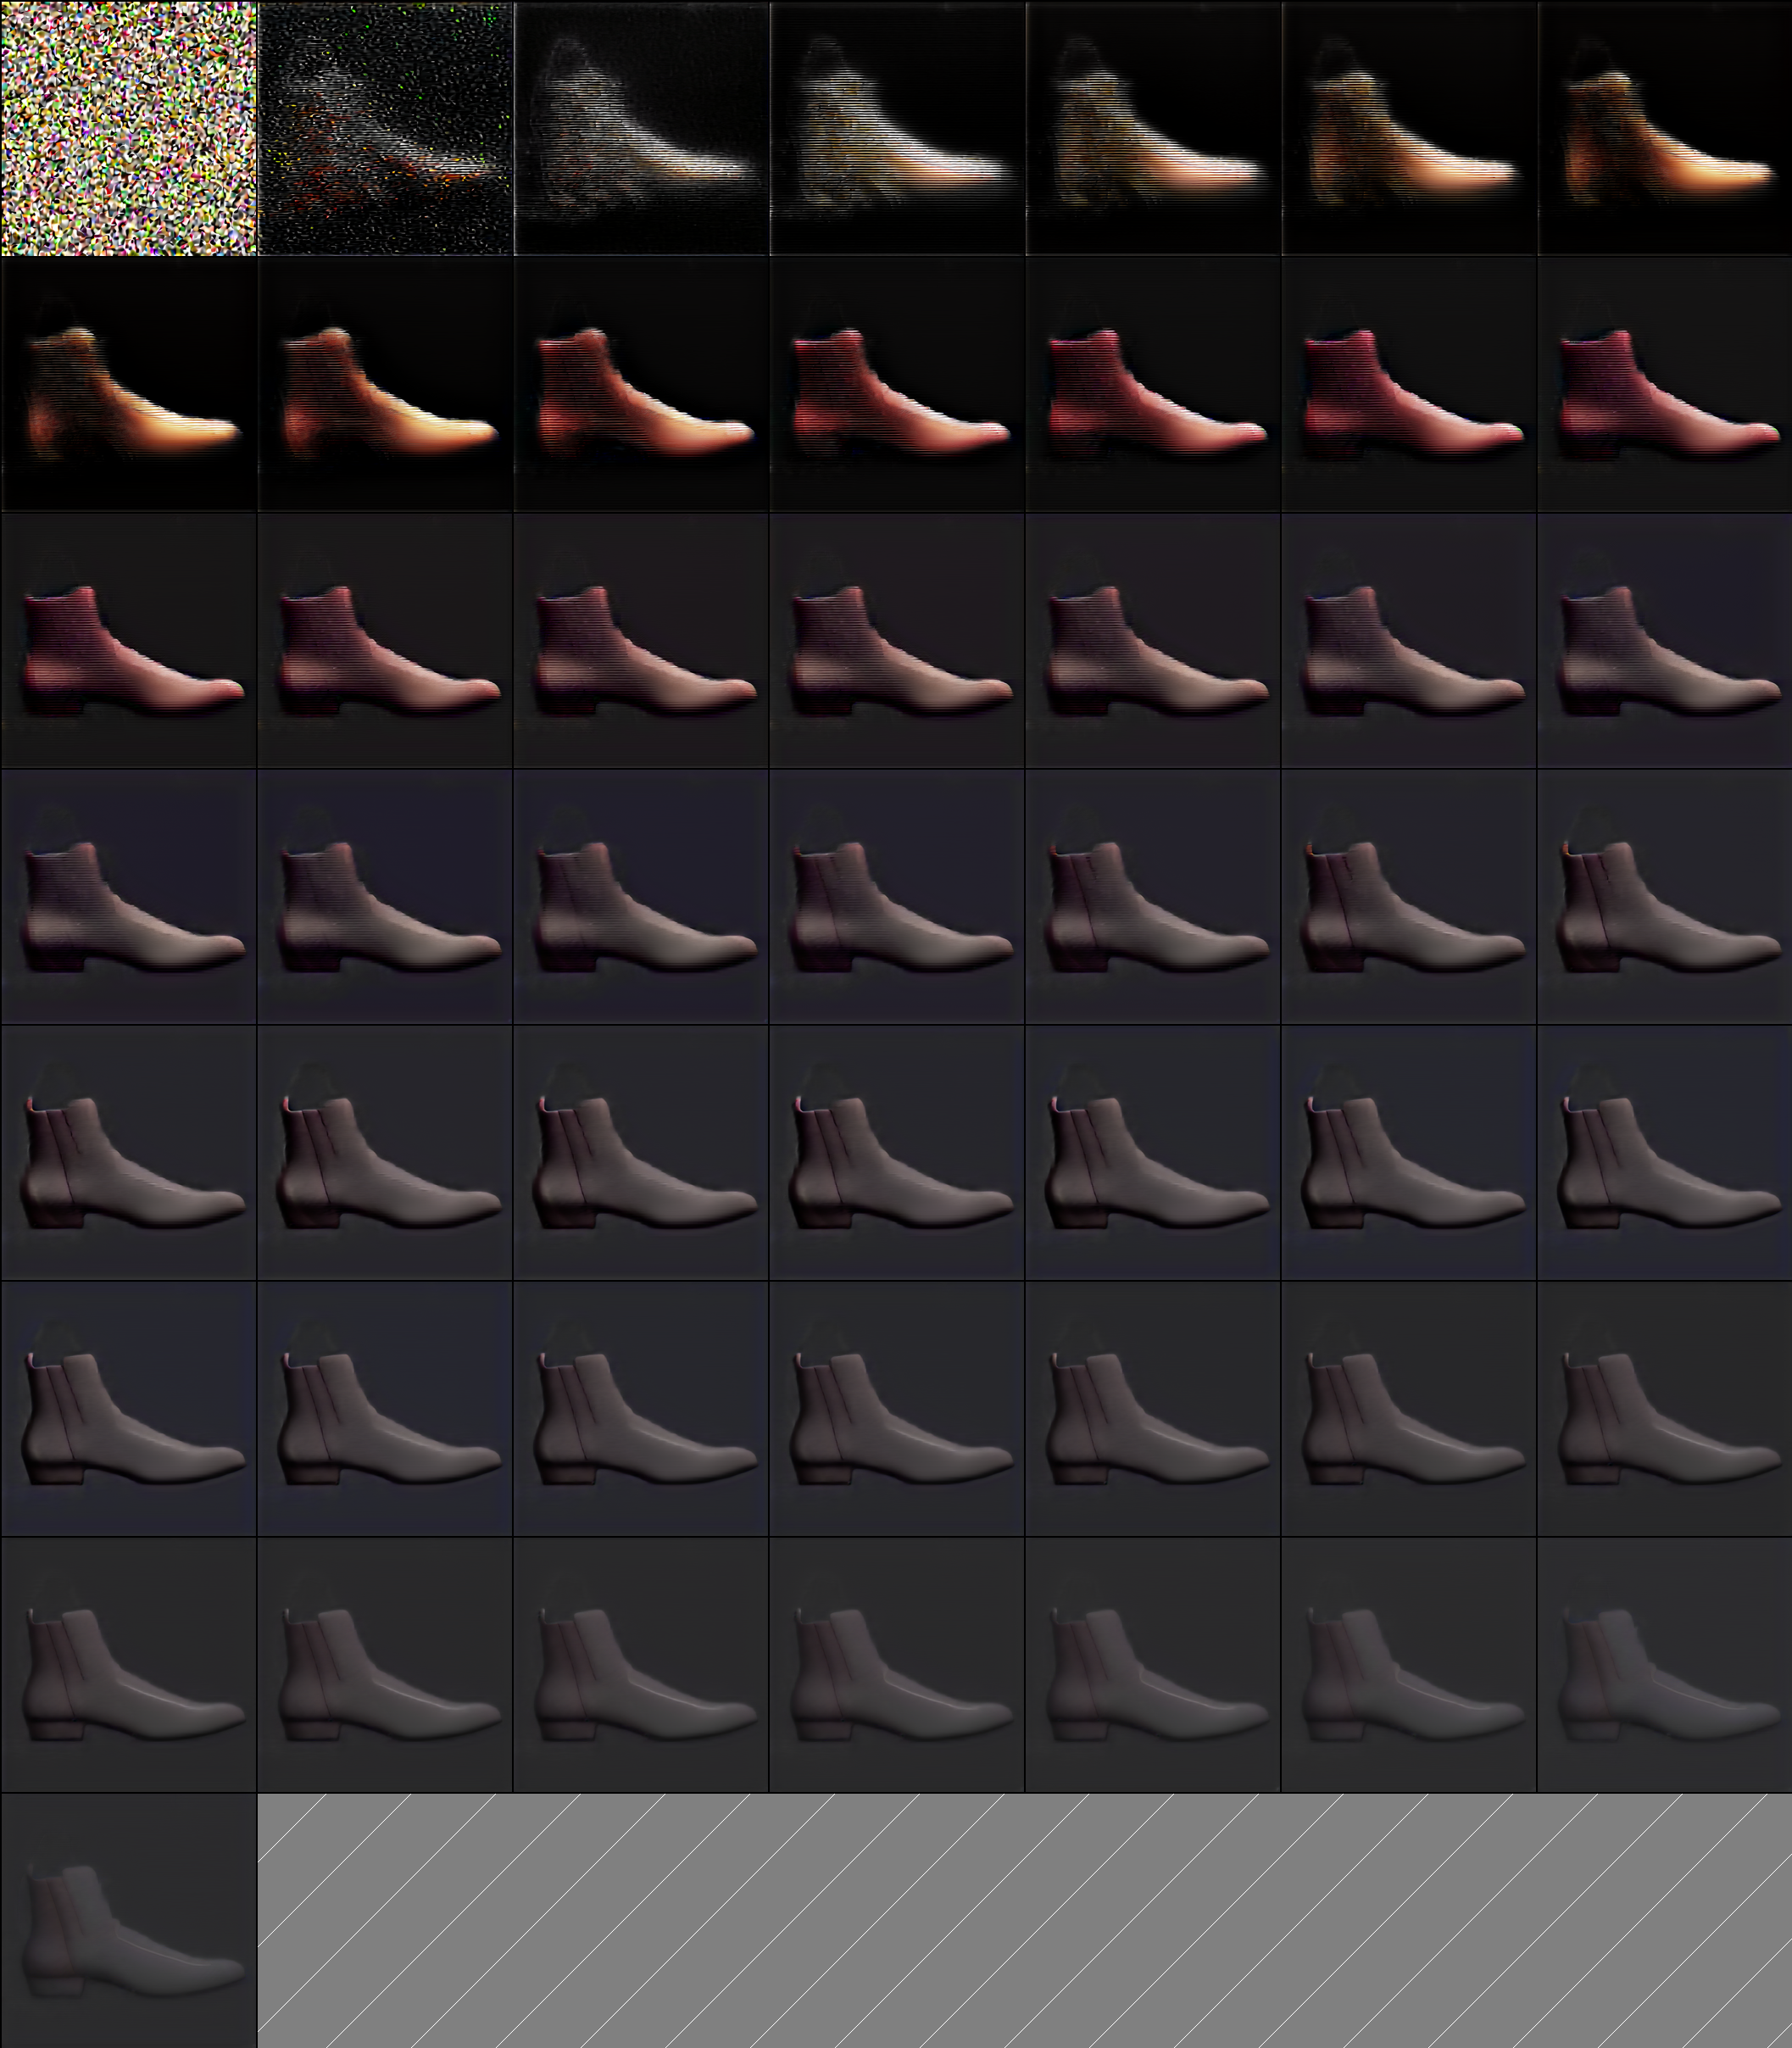

In [23]:
grid

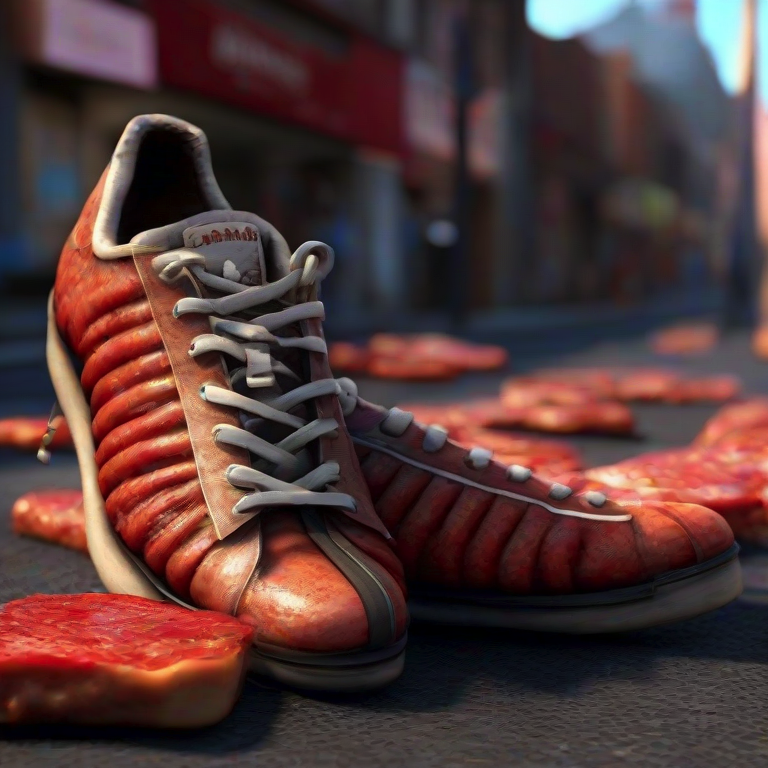

In [24]:
image